# NetCDF handling

NetCDF formatted files are much faster to read and write for large datasets. In order to make the most of this, both the `ScmDataFrame` and `ScmRun` objects have the ability to read and write netCDF files.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from glob import glob

import numpy as np
import seaborn as sns
import xarray as xr

from scmdata.run import ScmRun, run_append
from scmdata.netcdf import nc_to_run

## Helper bits and piecs

In [2]:
OUT_FNAME = "/tmp/out_runs.nc"

In [3]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model scenario                        variable region   unit  run_id
	0   example   ssp119             Surface Temperature  World      K       0
	1   example   ssp119  Atmospheric Concentrations|CO2  World    ppm       0
	2   example   ssp119               Radiative Forcing  World  W/m^2       0
	3   example   ssp119             Surface Temperature  World      K       1
	4   example   ssp119  Atmospheric Concentrations|CO2  World    ppm       1
	5   example   ssp119               Radiative Forcing  World  W/m^2       1
	6   example   ssp119             Surface Temperature  World      K       2
	7   example   ssp119  Atmospheric Concentrations|CO2  World    ppm       2
	8   example   ssp119               Radiative Forcing  World  W/m^2       2
	9   example   ssp119             Surface Temperature  World      K       3
	10  example   ssp119  Atmospheric Concentratio

## Reading/Writing to NetCDF4

### Basics

Writing the runs to disk is easy. The one trick is that each variable and dimension combination must have unique metadata. If they do not, you will receive an error message like the below.

In [5]:
try:
    runs.to_nc(OUT_FNAME, dimensions=["region"])
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: ['region'] dimensions are not unique for variable Atmospheric Concentrations|CO2


In our dataset, there is more than one "run_id" per variable hence we need to use a different dimension, `run_id`, because this will result in each variable's remaining metadata being unique.

In [6]:
runs.to_nc(OUT_FNAME, dimensions=["run_id"])

The output netCDF file can be read using the `from_nc` method, `nc_to_run` function or directly using `xarray`.

In [7]:
# NBVAL_IGNORE_OUTPUT
runs_netcdf = ScmRun.from_nc(OUT_FNAME)
runs_netcdf

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable   unit scenario region    model
	30       0  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	31       1  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	32       2  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	33       3  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	34       4  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	35       5  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	36       6  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	37       7  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	38       8  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	39       9  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	40       0               Radiative Forcing  W/

In [8]:
# NBVAL_IGNORE_OUTPUT
nc_to_run(ScmRun, OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable   unit scenario region    model
	60       0  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	61       1  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	62       2  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	63       3  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	64       4  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	65       5  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	66       6  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	67       7  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	68       8  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	69       9  Atmospheric Concentrations|CO2    ppm   ssp119  World  example
	70       0               Radiative Forcing  W/

In [9]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(OUT_FNAME)

<xarray.Dataset>
Dimensions:                          (run_id: 10, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, time) float64 0.0 0.4104 ... 69.66
    Radiative_Forcing                (run_id, time) float64 0.0 0.9053 ... 42.5
    Surface_Temperature              (run_id, time) float64 0.0 ... 68.01
Attributes:
    created_at:        2020-07-30T01:51:47.750174
    _scmdata_version:  0.6.1+31.g79c4e54.dirty
    source:            fake data

The additional `metadata` in `runs` is also serialized and deserialized in the netCDF files. The `metadata` of the loaded `ScmRun` will also contain some additional fields about the file creation.

In [10]:
# NBVAL_IGNORE_OUTPUT
assert "source" in runs_netcdf.metadata
runs_netcdf.metadata

{'created_at': '2020-07-30T01:51:47.750174',
 '_scmdata_version': '0.6.1+31.g79c4e54.dirty',
 'source': 'fake data'}

### Splitting your data

Sometimes if you have complicated ensemble runs it might be more efficient to split the data into smaller subsets.

In the below example we iterate over scenarios to produce a netCDF file per scenario.

In [11]:
large_run = []

# 10 runs for each scenario
for sce in ["ssp119", "ssp370", "ssp585"]:
    large_run.extend(
        [
            new_timeseries(
                count=3,
                scenario=sce,
                variable=[
                    "Surface Temperature",
                    "Atmospheric Concentrations|CO2",
                    "Radiative Forcing",
                ],
                unit=["K", "ppm", "W/m^2"],
                paraset_id=paraset_id,
            )
            for paraset_id in range(10)
        ]
    )

large_run = run_append(large_run)

# also set a run_id (often we'd have paraset_id and run_id,
# one which keeps track of the parameter set we've run and
# the other which keeps track of the run in a large ensemble)
large_run["run_id"] = large_run.meta.index.values
large_run

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model scenario                        variable region   unit  \
	90   example   ssp119             Surface Temperature  World      K   
	91   example   ssp119  Atmospheric Concentrations|CO2  World    ppm   
	92   example   ssp119               Radiative Forcing  World  W/m^2   
	93   example   ssp119             Surface Temperature  World      K   
	94   example   ssp119  Atmospheric Concentrations|CO2  World    ppm   
	..       ...      ...                             ...    ...    ...   
	175  example   ssp585  Atmospheric Concentrations|CO2  World    ppm   
	176  example   ssp585               Radiative Forcing  World  W/m^2   
	177  example   ssp585             Surface Temperature  World      K   
	178  example   ssp585  Atmospheric Concentrations|CO2  World    ppm   
	179  example   ssp585               Radiative Forcing  World  W/m^2   
	
	     paraset_id 

For such a data set, since both `run_id` and `paraset_id` vary, both could be added as dimensions in the file.

The one problem with this approach is that you get very sparse arrays because the data is written on a 100 x 30 x 90 (time points x paraset_id x run_id) grid but there's only 90 timeseries so you end up with 180 timeseries worth of nans (although this is a relatively small problem because the netCDF files use compression to minismise the impact of the extra nan values).

In [12]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-sparse.nc".format(sce),
        dimensions=["run_id", "paraset_id"],
    )

In [13]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-sparse.nc")

<xarray.Dataset>
Dimensions:                          (paraset_id: 10, run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 150 151 152 ... 177 178 179
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (run_id, paraset_id, time) float64 nan ....
    Radiative_Forcing                (run_id, paraset_id, time) float64 nan ....
    Surface_Temperature              (run_id, paraset_id, time) float64 0.0 ....
Attributes:
    created_at:        2020-07-30T01:51:48.047550
    _scmdata_version:  0.6.1+31.g79c4e54.dirty

Data for each scenario can then be loaded independently instead of having to load all the data and then filtering

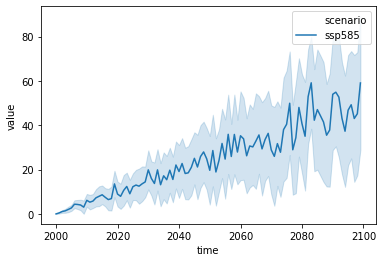

In [14]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-sparse.nc").filter(
    "Surface Temperature"
).line_plot()

In [15]:
# NBVAL_IGNORE_OUTPUT
# Load all scenarios
run_append([ScmRun.from_nc(fname) for fname in glob("/tmp/out-*-sparse.nc")])

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	     run_id  paraset_id                        variable unit scenario region  \
	210     121           0  Atmospheric Concentrations|CO2  ppm   ssp370  World   
	211     124           1  Atmospheric Concentrations|CO2  ppm   ssp370  World   
	212     127           2  Atmospheric Concentrations|CO2  ppm   ssp370  World   
	213     130           3  Atmospheric Concentrations|CO2  ppm   ssp370  World   
	214     133           4  Atmospheric Concentrations|CO2  ppm   ssp370  World   
	..      ...         ...                             ...  ...      ...    ...   
	295     165           5             Surface Temperature    K   ssp585  World   
	296     168           6             Surface Temperature    K   ssp585  World   
	297     171           7             Surface Temperature    K   ssp585  World   
	298     174           8             Surface Temperature    K   ssp585  W

An alternative to the sparse arrays is to specify the variables in the `extras` attribute. This adds the metadata to the netCDF file as an additional variable with the same dimensions as the data (except for `time` for obvious reasons).

In [16]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-extras.nc".format(sce),
        dimensions=["run_id"],
        extras=["paraset_id"],
    )

In [17]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-extras.nc")

<xarray.Dataset>
Dimensions:                          (run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 150 151 152 ... 177 178 179
Data variables:
    paraset_id                       (run_id) int64 0 0 0 1 1 1 ... 8 8 8 9 9 9
    Atmospheric_Concentrations__CO2  (run_id, time) float64 nan nan ... nan nan
    Radiative_Forcing                (run_id, time) float64 nan nan ... 7.608
    Surface_Temperature              (run_id, time) float64 0.0 0.3864 ... nan
Attributes:
    created_at:        2020-07-30T01:51:48.469935
    _scmdata_version:  0.6.1+31.g79c4e54.dirty

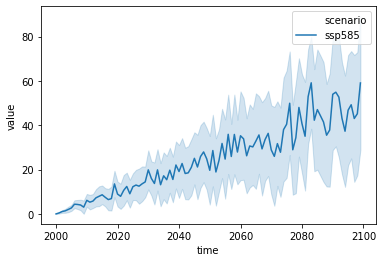

In [18]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-extras.nc").filter(
    "Surface Temperature"
).line_plot()

### Multi-dimensional data

**scmdata** can also handle having more than one dimension. This can be especially helpful if you have output from a number of models (IAMs), scenarios, regions and runs.

In [19]:
multi_dimensional_run = []

for model in ["AIM", "GCAM", "MESSAGE", "REMIND"]:
    for sce in ["ssp119", "ssp370", "ssp585"]:
        for region in ["World", "R5LAM", "R5MAF", "R5ASIA", "R5OECD", "R5REF"]:
            multi_dimensional_run.extend(
                [
                    new_timeseries(
                        count=3,
                        model=model,
                        scenario=sce,
                        region=region,
                        variable=[
                            "Surface Temperature",
                            "Atmospheric Concentrations|CO2",
                            "Radiative Forcing",
                        ],
                        unit=["K", "ppm", "W/m^2"],
                        paraset_id=paraset_id,
                    )
                    for paraset_id in range(10)
                ]
            )

multi_dimensional_run = run_append(multi_dimensional_run)

multi_dimensional_run

<scmdata.ScmRun (timeseries: 2160, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model scenario                        variable region   unit  \
	330      AIM   ssp119             Surface Temperature  World      K   
	331      AIM   ssp119  Atmospheric Concentrations|CO2  World    ppm   
	332      AIM   ssp119               Radiative Forcing  World  W/m^2   
	333      AIM   ssp119             Surface Temperature  World      K   
	334      AIM   ssp119  Atmospheric Concentrations|CO2  World    ppm   
	...      ...      ...                             ...    ...    ...   
	2485  REMIND   ssp585  Atmospheric Concentrations|CO2  R5REF    ppm   
	2486  REMIND   ssp585               Radiative Forcing  R5REF  W/m^2   
	2487  REMIND   ssp585             Surface Temperature  R5REF      K   
	2488  REMIND   ssp585  Atmospheric Concentrations|CO2  R5REF    ppm   
	2489  REMIND   ssp585               Radiative Forcing  R5REF  W/m^2   
	
	      paraset_

In [20]:
multi_dim_outfile = "/tmp/out-multi-dimensional.nc"

In [21]:
multi_dimensional_run.to_nc(
    multi_dim_outfile,
    dimensions=("region", "model", "scenario", "paraset_id"),
)

In [22]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(multi_dim_outfile)

<xarray.Dataset>
Dimensions:                          (model: 4, paraset_id: 10, region: 6, scenario: 3, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * region                           (region) object 'R5ASIA' ... 'World'
  * model                            (model) object 'AIM' 'GCAM' ... 'REMIND'
  * scenario                         (scenario) object 'ssp119' ... 'ssp585'
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    Atmospheric_Concentrations__CO2  (region, model, scenario, paraset_id, time) float64 ...
    Radiative_Forcing                (region, model, scenario, paraset_id, time) float64 ...
    Surface_Temperature              (region, model, scenario, paraset_id, time) float64 ...
Attributes:
    created_at:        2020-07-30T01:51:51.703631
    _scmdata_version:  0.6.1+31.g79c4e54.dirty

In [23]:
# NBVAL_IGNORE_OUTPUT
multi_dim_loaded_co2_conc = ScmRun.from_nc(multi_dim_outfile).filter(
    "Atmospheric Concentrations|CO2"
)

seaborn_df = multi_dim_loaded_co2_conc.long_data()
seaborn_df.head()

,region,model,scenario,paraset_id,variable,unit,time,value
0,R5ASIA,AIM,ssp119,0,Atmospheric Concentrations|CO2,ppm,2000-01-01,0.000000
1,R5ASIA,AIM,ssp119,0,Atmospheric Concentrations|CO2,ppm,2001-01-01,0.656046
2,R5ASIA,AIM,ssp119,0,Atmospheric Concentrations|CO2,ppm,2002-01-01,0.914121
3,R5ASIA,AIM,ssp119,0,Atmospheric Concentrations|CO2,ppm,2003-01-01,0.588460
4,R5ASIA,AIM,ssp119,0,Atmospheric Concentrations|CO2,ppm,2004-01-01,3.764576


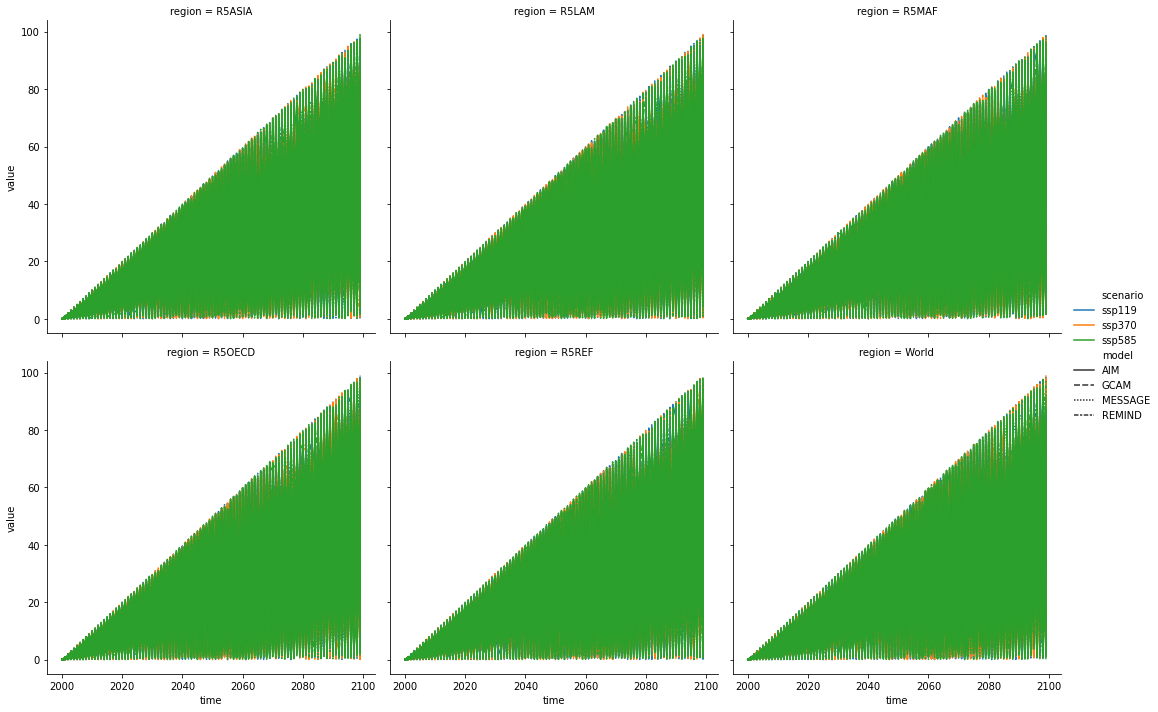

In [24]:
# NBVAL_IGNORE_OUTPUT
sns.relplot(
    data=seaborn_df,
    x="time",
    y="value",
    units="paraset_id",
    estimator=None,
    hue="scenario",
    style="model",
    col="region",
    col_wrap=3,
    kind="line",
)